In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np

from pdg.pdg import PDG
from pdg.dist import RawJointDist as RJD
from pdg.lib import A,B,C,D
from pdg.lib.square import consist_with_P, P #, with_indeps

In [3]:
# μ_opt = with_indeps.optimize_score(gamma=0.001, tol=1E-30)
φ = consist_with_P.factor_product(repr='atomic')
μCP_opt1, μCP_iter1 = consist_with_P.optimize_score(gamma=1, store_iters=True)
μCP_opt0, μCP_iter0 = consist_with_P.optimize_score(gamma=0, store_iters=True)

In [4]:
μCP_GS_ord, μCP_iterGSo = consist_with_P.iter_GS_ordered(store_iters=True)
μCP_GS_β, μCP_iterGSβ = consist_with_P.iter_GS_beta(store_iters=True)

It should be the case that any unweighted PDG $M$ will have the same distribution $q_{\gamma=0}$ that minimizes its semantics $ [[ M ]]$ at $\gamma=1$, which is equal to its factor product $\Pr_{\varphi_{M}}$.

What GIbbs sampling do to $\mathit{Inc}$ and $\mathit{IDef}$?

So... let's set up a PCA to visualize what's happening. with both optimizations, $P$, and $\varphi$

In [5]:
SHAPE = φ.data.reshape(-1).shape

Ppt = np.array([P.data.reshape(*SHAPE)])
φpt = np.array([φ.data.reshape(*SHAPE)])
idx0pt = np.linspace(0, 1, len(μCP_iter0))
idx1pt = np.linspace(0, 1, len(μCP_iter1))

iter0pt = np.array(μCP_iter0)
iter1pt = np.array(μCP_iter1)
bigmatrix = np.vstack([Ppt, φpt, iter0pt, iter1pt])

def iitransform(M, μflatmat):
    return [(M.Inc(μ).real,M.IDef(μ).real) for μ in map(lambda d : RJD(d.reshape(*M.dshape), M.varlist), μflatmat)]

%matplotlib widget

# Do for γ=0 (P)
plt.plot(*zip(*iitransform(consist_with_P, iter0pt[0:])), 'b', alpha=0.1)
plt.scatter(*zip(*iitransform(consist_with_P, iter0pt)), cmap='Purples', c=idx0pt, alpha=0.3)
Xs,Ys = zip(*iitransform(consist_with_P, [Ppt])); plt.plot(Xs,Ys, '*w', markersize=15,alpha=0.8)
Xs,Ys = zip(*iitransform(consist_with_P, [μCP_opt0.data])); plt.plot(Xs,Ys, 'xb', markersize=15,alpha=0.8)
plt.annotate

# Do for γ=1 (φ)
plt.plot(*zip(*iitransform(consist_with_P, iter1pt[0:])), 'r', alpha=0.1)
plt.scatter(*zip(*iitransform(consist_with_P, iter1pt)), cmap='Oranges', c=idx1pt, alpha=0.3)
Xs,Ys = zip(*iitransform(consist_with_P, [φpt])); plt.plot(Xs,Ys, 'or', markersize=15,alpha=0.8)
Xs,Ys = zip(*iitransform(consist_with_P, [μCP_opt1.data])); plt.plot(Xs,Ys, 'xr', markersize=15,alpha=0.8)

#now for GS
plt.plot(*zip(*iitransform(consist_with_P, μCP_iterGSo)), 'g', alpha=0.1)
plt.scatter(*zip(*iitransform(consist_with_P, μCP_iterGSo)), cmap='Greens', c=np.linspace(0,1,len(μCP_iterGSo)), alpha=0.3)
Xs,Ys = zip(*iitransform(consist_with_P, [μCP_GS_ord.data])); plt.plot(Xs,Ys, '+g', markersize=15,alpha=0.8)

plt.plot(*zip(*iitransform(consist_with_P, μCP_iterGSβ)), 'k', alpha=0.1)
plt.scatter(*zip(*iitransform(consist_with_P, μCP_iterGSβ)), cmap='Greys', c=np.linspace(0,1,len(μCP_iterGSβ)), alpha=0.3)
Xs,Ys = zip(*iitransform(consist_with_P, [μCP_GS_β.data])); plt.plot(Xs,Ys, 'xk', markersize=15,alpha=0.8)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

~~Weirld, that the optimziation does not quite get either the oange dot (the distribution $P$ which is supposed to be the # of factors), and also that the blue one does not minimize Inc. I need to make sure the gradient is correct.... and then implement accelerated gradient descent properly?~~

**Update Aug 2021**: It looks to me that the orange dot (factor product) does indeed coincide with the optimum $\mu^*_{\gamma=1}$, and also that everything has non-negative Inc, with $\mu^*_{\gamma=0}$ and the DN iterates almost exactly the same place.

The big question: is it the case that $\mu^* := \lim_{\gamma\to 0} [\![\mathcal M]\!]^*_\gamma$ has the same IDef as $\mu^*_\beta$, the DN iterate? We know it must be no larger.  For a counter-example, we would only need to show that $\mathrm{IDef}(\mu^*_\beta) > \mathrm{IDef}(\mu^*)$ strictly. And since the DN iterates converge, this would be be a counter-example even for an approximate $\mu^*$. 

Of course, in the

# Debugging the Gradient for $\gamma=0$

In [10]:
M = consist_with_P
mscore = M._build_fast_scorer(gamma=0)

mscore(μCP_GS_β.data)[0], mscore(μCP_opt0.data)[0] # uh-oh...

(0.0, -3.2034265038149176e-16)

Clearly the optimization isn't working properly. But this should be a convex function... let's look at the supposed gradients.

In [11]:
(mscore(μCP_GS_β.data)[1]**2).sum(), (mscore(μCP_opt0.data)[1]**2).sum()

(9.33914424106988e-25, 1.8314354197026343e-14)

So the gradient of the optimal is much larger... does it point towards the optimum?

In [12]:
xopt = μCP_GS_β.data.reshape(-1)
x = μCP_opt0.data.reshape(-1)
gradx = mscore(x)[1]
gradx /=  np.sqrt((gradx*gradx).sum())

vec = (xopt - x)
vec /= np.sqrt((vec*vec).sum())
ϵ = 0.00001

# np.allclose(vec.reshape(-1).dot(vec.reshape(-1)), (vec*vec).sum().reshape(-1))  #True
print("score @ x: %.7f;\t score @ x + ϵ·grad: %.7f;\t  score @x + ϵ·v: %.7f"%
      (mscore(x)[0], mscore(x + gradx*ϵ)[0], mscore(x + vec * ϵ)[0]))

score @ x: -0.0000000;	 score @ x + ϵ·grad: 0.0000061;	  score @x + ϵ·v: -0.0000000


# Debugging the Gradient for $\gamma=1$

In [18]:
M = consist_with_P
mscore = M._build_fast_scorer(gamma=1)

mscore(φ.data)[0], mscore(μCP_opt1.data)[0] # uh oh

(-0.6095564755212859, 2.253147918557464)

What are the debug messages?

In [19]:
np.set_printoptions(precision=2)
# mscore(μCP_opt1.data, debug=True)

In [ ]:
μCP_opt1, μCP_iter1 = consist_with_P.optimize_score(gamma=1, store_iters=True)
print(consist_with_P._opt_rslt)

In [22]:
xopt = φ.data.reshape(-1)
x = μCP_opt1.data.reshape(-1)
gradx = mscore(x)[1]
gradx /=  np.sqrt((gradx*gradx).sum())

vec = (xopt - x)
vec /= np.sqrt((vec*vec).sum())
ϵ = 0.001

# np.allclose(vec.reshape(-1).dot(vec.reshape(-1)), (vec*vec).sum().reshape(-1))  #True
print("score @ x: %.7f;\t score @ x + ϵ·grad: %.7f;\t  score @x + ϵ·v: %.7f"%
      (mscore(x)[0], mscore(x + gradx*ϵ)[0], mscore(x + vec * ϵ)[0]))

score @ x: -0.6095565;	 score @ x + ϵ·grad: -0.5828957;	  score @x + ϵ·v: -0.6092460


## Now, a function to do this for a `DistLibrary`

In [68]:
"""
Usage:
 convergence_plot(lib.opt, along="γ", cmap='Blues', marker='X', lines=False)
Semantics:
 (1) scatter all distributions in view
 (2) special marker on smallest dist if exists
 (3) if along + cmap specified, 
"""
def convergence_plot(dlibview, along=None, lines=None, **kwargs):
    def iitransform(μs):
        return zip(*((M.Inc(μ).real,M.IDef(μ).real) for μ in μs))

    M = dlibview._lib.M
    X,Y = iitransform(dlibview.μs if along is None else dlibview.along(along))
    
    if lines:
        if type(lines) is str:
            plt.plot(X,Y, lines, alpha=0.2)
        else:
            linedict = {'color' : '#999999', 'alpha': 0.3 }
            if 'cmap' in kwargs:
                linedict['color'] = plt.get_cmap(kwargs['cmap'])(0.5)

            if isinstance(lines,dict):
                linedict.update(**lines)

            plt.plot(X,Y, **linedict)
        
    
    plt.scatter(X,Y, c=np.linspace(0,1,len(X)), **kwargs)

    x = None; y = None
    try:
        x,y = iitransform([+dlibview])
    except ValueError:
        # not a unique natural special distribution
        if along is not None:
            x,y = X[-1], Y[-1]
    
    if not (x is None or y is None):
        plt.scatter(x,y,marker='x',s=130,alpha=1) 

In [34]:
# def convergence_plot(initM, precomputed = None, *distfmtpairs, lines=False):
#     Γ = StandardDists(M)  if precomputed is None else precomputed
#     M = Γ.M

#     SHAPE = Γ.φ.data.reshape(-1).shape

#     φpt = np.array([Γ.φ.data.reshape(*SHAPE)])
#     idx0pt = np.linspace(0, 1, len(Γ.μiter0))
#     idx1pt = np.linspace(0, 1, len(Γ.μiter1))
    
#     bigmatrix = np.vstack([φpt, Γ.μiter0, Γ.μiter1])

#     def iitransform(μflatmat):
#         return [(M.Inc(μ),M.IDef(μ)) for μ in map(lambda d : RJD(d.reshape(*M.dshape), M.varlist), μflatmat)]


#     # Do for γ=0 (P)
#     if lines: plt.plot(*zip(*iitransform( Γ.μiter0)), 'b', alpha=0.1)
#     plt.scatter(*zip(*iitransform( Γ.μiter0)), cmap='Blues', c=idx0pt, alpha=0.3)
#     Xs,Ys = zip(*iitransform( [Γ.μopt0.data])); plt.plot(Xs,Ys, 'xb', markersize=15,alpha=0.8)

#     # Do for γ=1 (φ)
#     if lines: plt.plot(*zip(*iitransform( Γ.μiter1)), 'r', alpha=0.1)
#     plt.scatter(*zip(*iitransform(Γ.μiter1)), cmap='Reds', c=idx1pt, alpha=0.3)
#     Xs,Ys = zip(*iitransform( [φpt])); plt.plot(Xs,Ys, '>r', markersize=15,alpha=0.8)
#     Xs,Ys = zip(*iitransform( [Γ.μopt1.data])); plt.plot(Xs,Ys, 'xr', markersize=15,alpha=0.8)
    
#     # Do for γ=ϵ 
#     if lines: plt.plot(*zip(*iitransform( Γ.μiterϵ)), 'k', alpha=0.1)
#     plt.scatter(*zip(*iitransform(Γ.μiterϵ)), cmap='Purples', c=np.linspace(0,1,len(Γ.μiterϵ)), alpha=1)
#     Xs,Ys = zip(*iitransform( [Γ.μoptϵ.data])); plt.plot(Xs,Ys, 'Xk', markersize=17,alpha=0.8)

#     #now for GS
#     if lines: plt.plot(*zip(*iitransform( Γ.iterGSo)), 'g', alpha=0.1)
#     plt.scatter(*zip(*iitransform( Γ.iterGSo)), cmap='Greens', c=np.linspace(0,1,len(Γ.iterGSo)), alpha=0.3)
#     Xs,Ys = zip(*iitransform( [Γ.μord.data])); plt.plot(Xs,Ys, 'xg',
#                                                         markeredgecolor='k', markersize=15,alpha=0.8)

#     if lines: plt.plot(*zip(*iitransform( Γ.iterGSβ)), 'y', alpha=0.2)
#     plt.scatter(*zip(*iitransform( Γ.iterGSβ)), cmap='Wistia', c=np.linspace(0,1,len(Γ.iterGSβ)), alpha=0.3)
#     Xs,Ys = zip(*iitransform([Γ.μGS_β.data])); plt.plot(Xs,Ys, marker='+y',
#                                                         markeredgecolor='k', markersize=15,alpha=0.8)
    
#     for d,f in distfmtpairs:
#         plt.plot(*zip(*iitransform( [d.data] )), f)
        

#     plt.show()

In [26]:
from lib import smoking
CP_lib = consist_with_P.standard_library()
smoking_lib = smoking.M.standard_library()

In [ ]:
from lib.square import with_rand_cpts, missing_parents
wrc = with_rand_cpts.standard_library

In [3]:
import pickle, os


True

In [2]:
load = False
fnames = ['CP_lib', 'smoking_lib']

if load:
    for f in fnames:
        with open(f+'.pkl', 'rb') as f:
            globals()[f] = dist.DistLibrary(, pickle.read(f))

    with open("CP_lib.pkl", 'rb') as f:
        CP_lib = dist.DistLibrary(consistent_with_P, pickle.read(f)
    with open("smoking_lib.pkl", 'rb') as f:
        pickle.dump(smoking_lib.dists, f)
with open("CP_lib.pkl", 'wb') as f:
    pickle.dump(CP_lib.dists, f)
with open("smoking_lib.pkl", 'wb') as f:
    pickle.dump(smoking_lib.dists, f)

SyntaxError: invalid syntax (<ipython-input-2-9571cd5310ec>, line 4)

In [ ]:
import pickle


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

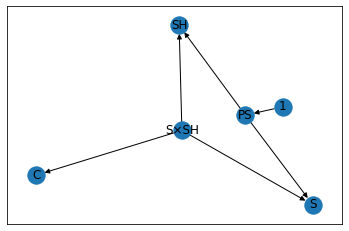

In [281]:
%matplotlib widget
smoking_lib.M.draw()

In [251]:
for k,d in CP_lib.dists.items():
    if not isinstance(d, np.ndarray):
        CP_lib.dists[k] = d.data.reshape(-1)

In [35]:
%matplotlib widget
# plt.figure(figsize=(10,4))
convergence_plot(CP_lib.GS.β, along='i', cmap='Oranges',linecolor=...)
convergence_plot(CP_lib.GS("≺"), along='i', cmap='Blues',linecolor=...)

# convergence_plot(smoking_lib.opt, along="γ",cmap='Blues')#,linecolor="#aaaaff"


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

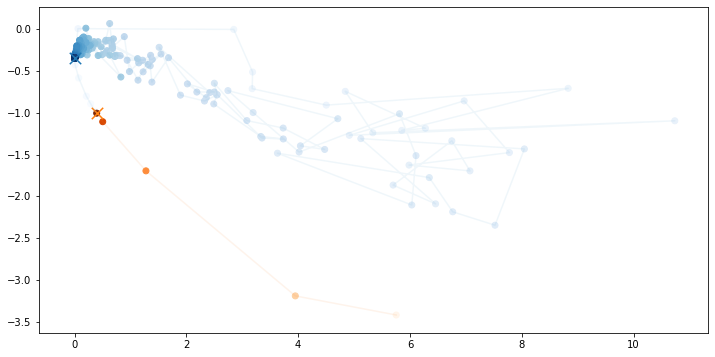

In [158]:
%matplotlib widget
plt.figure(figsize=(12,6))
convergence_plot(CP_lib.opt.γ(lambda γ: γ < 1), along="-γ",cmap='Blues', lines={'alpha':0.1})#
convergence_plot(CP_lib.opt.γ(lambda γ: γ > 1), along="-γ",cmap='Oranges', lines={'alpha':0.1})#

In [1]:
%matplotlib inline
plt.figure(figsize=(10,4))
convergence_plot(smoking_lib.opt.without("i"), along="-γ",cmap='Blues', lines={'alpha':0.1})#

NameError: name 'plt' is not defined

In [86]:
smoking_lib.opt.γ

LibView { opt } (43 matches)

In [70]:
from pdg import DistLibrary
dl = DistLibrary(smoking.M)

LibraryView {  }

In [282]:
%matplotlib widget
convergence_plot(..., CP_lib, (P, '*c'))

AttributeError: 'ellipsis' object has no attribute '_lib'

In [30]:
%matplotlib widget
convergence_plot(..., smoke_lib)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
import pandas as pd
print(consist_with_P.score(μCP_fact, gamma=1),
          consist_with_P.score(μCP_opt1, gamma=1),
          consist_with_P.score(RJD.unif(consist_with_P.varlist),gamma=1))
pd.concat([μCP_fact[B | A], μCP_opt1[B | A]],axis=1)


mscore = consist_with_P._build_fast_scorer(gamma=1)
goodscore = consist_with_P.score

unif = RJD.unif(consist_with_P.varlist)

[ (mscore(μ.data)[0], goodscore(μ)) for μ in [μ_fact, P, unif]]


# Convergence
Does $p^*$ =


In [ ]:
# Optimizing for Inc alone gives small Inc
consist_with_P.Inc(μCP_opt0)

In [ ]:
# And the original distribution P from which it was taken, is not SO far away.
# Note: opt0 is more generic; easier to specialize  μ_fact_opt <- P  than vice versa
P // μCP_opt0,    μCP_opt0 // P

In [ ]:

μAB = RJD(np.zeros((2,3))+np.eye(2,3)/2 + np.random.random((2,3))/100, [A,B])
μAB.info_diagram(A,B,B)